In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

import metpy.calc as mpcalc

#### Define case and path

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [3]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

#### Get grid

In [4]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [5]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT
area_x1=ds_grid_x1.TAREA
area_m_x1=ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = utils.normal_lons(lons_x1)

#### Define variable list

In [6]:
variables = ['photoC_diaz_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [7]:
def preprocess(ds):
    ds=ds.mean(dim='time')
    return ds

In [8]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint


In [9]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [10]:
ds_fosi_x01

<xarray.Dataset>
Dimensions:            (d2: 2, nlat: 2400, nlon: 3600, time: 768, z_t: 62, z_t_150m: 15)
Coordinates:
  * z_t                (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m           (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time               (time) object 1958-01-16 12:15:50.000002 ... 2021-12-1...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    dz                 (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    time_bound         (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    photoC_diaz_zint   (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    photoC_sp_zint     (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    photoC_cocco_zint  (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>

In [11]:
ds_fosi_x01['photoC_TOT_zint'] = ds_fosi_x01['photoC_cocco_zint'] + ds_fosi_x01['photoC_diat_zint'] + ds_fosi_x01['photoC_diaz_zint'] + ds_fosi_x01['photoC_sp_zint']

### spin up dask

In [12]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='06:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [13]:
cluster, client = get_ClusterClient()
cluster.scale(24) 

In [14]:
client

Client Scheduler: tcp://128.117.208.85:34015 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Resample for annual means

In [15]:
#%%time
ds_fosi_x01_ann = ds_fosi_x01.resample({'time':'A'}).mean(dim='time').compute()

In [16]:
ds_mean = ds_fosi_x01_ann.mean(dim='time')

In [17]:
ones = np.full((2400,3600),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

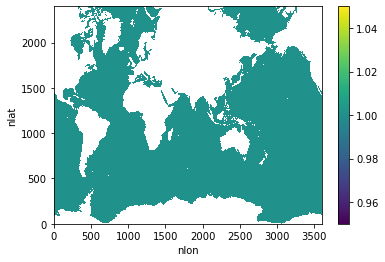

In [18]:
ones.plot()

In [19]:
ones_x1 = np.full((384,320),1,dtype=int)
ones_x1 = xr.DataArray(ones_x1,dims=('nlat','nlon'))
ones_x1 = ones_x1.where(ds_grid_x1.REGION_MASK>0)

### Read in LME masks for 0.1° and 1°

In [21]:
ds_lme_x01 = xr.open_dataset('/glade/u/home/kristenk/scope_analysis/data/LME-mask-POP_tx0.1v3.nc')

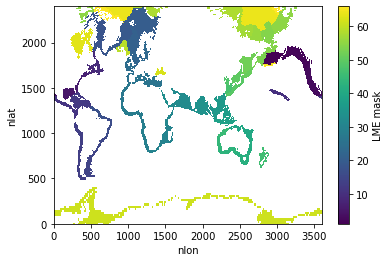

In [22]:
ds_lme_x01.lme_mask.plot()

In [23]:
ds_lme_x1 = xr.open_dataset('/glade/u/home/kristenk/scope_analysis/data/LME-mask-POP_gx1v6.nc')

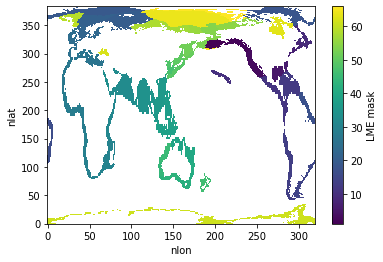

In [24]:
ds_lme_x1.lme_mask.plot()

### Now read in x1 data

In [25]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'
#path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1/'

In [26]:
ds_fosi_x1 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x1 = xr.merge([ds_fosi_x1,ds_tmp])

starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint


In [27]:
ds_fosi_x1["time"] = ds_fosi_x1.time_bound.compute().mean(dim="d2")

In [28]:
ds_fosi_x1['photoC_TOT_zint'] = ds_fosi_x1['photoC_cocco_zint'] + ds_fosi_x1['photoC_diat_zint'] + ds_fosi_x1['photoC_diaz_zint'] + ds_fosi_x1['photoC_sp_zint']

In [29]:
ds_fosi_x1_ann = ds_fosi_x1.resample({'time':'A'}).mean(dim='time').compute()

### Choose an few LMEs to examine

In [30]:
#### CA current (3), SE US shelf (6)
lme_nums = [3,6]

In [31]:
ts_by_lme_dict_x1 = {}
ts_by_lme_dict_x01 = {}

for lme in lme_nums:
    print('lme = ', lme)
    mask_x1 = ones_x1.where(ds_lme_x1.lme_mask == lme)
    mask_x01 = ones.where(ds_lme_x01.lme_mask == lme)
    
    masked_area_x1 = area_m_x1.where(ds_lme_x1.lme_mask == lme)
    masked_area_x01 = area_m.where(ds_lme_x01.lme_mask == lme)
    
    ds_tmp = xr.Dataset()
    ds_tmp2 = xr.Dataset()
    
    for v in variables:
        
        masked_var = ds_fosi_x1_ann[v].where(mask_x1==1)

        ds_tmp[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))

        masked_var = ds_fosi_x01_ann[v].where(mask_x01==1)

        ds_tmp2[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
    ### total NPP up here
    ds_tmp['photoC_TOT_zint'] = ds_tmp['photoC_diaz_zint'] + ds_tmp['photoC_diat_zint'] + ds_tmp['photoC_sp_zint'] + ds_tmp['photoC_cocco_zint']
    ds_tmp2['photoC_TOT_zint'] = ds_tmp2['photoC_diaz_zint'] + ds_tmp2['photoC_diat_zint'] + ds_tmp2['photoC_sp_zint'] + ds_tmp2['photoC_cocco_zint']
    
    ts_by_lme_dict_x1[lme] = ds_tmp
    ts_by_lme_dict_x01[lme] = ds_tmp2

lme =  3
lme =  6


In [32]:
ts_by_lme_dict_x01[3]

<xarray.Dataset>
Dimensions:            (time: 64)
Coordinates:
  * time               (time) object 1958-12-31 00:00:00 ... 2021-12-31 00:00:00
Data variables:
    photoC_diaz_zint   (time) float64 0.0008121 0.0008142 ... 0.0006827
    photoC_diat_zint   (time) float64 0.009052 0.01023 ... 0.008901 0.0104
    photoC_sp_zint     (time) float64 0.01868 0.01743 ... 0.01695 0.01657
    photoC_cocco_zint  (time) float64 0.003437 0.003719 ... 0.004407 0.005393
    photoC_TOT_zint    (time) float64 0.03198 0.03219 ... 0.03101 0.03304

In [33]:
variables = variables + ['photoC_TOT_zint']

In [34]:
variables

['photoC_diaz_zint',
 'photoC_diat_zint',
 'photoC_sp_zint',
 'photoC_cocco_zint',
 'photoC_TOT_zint']

### Choose an interesting region around Antarctica

In [35]:
############ Ross Sea
box1_latmin = -80.
box1_latmax = -70.
box1_lonmin = 165.
box1_lonmax = 195.

In [36]:
ts_Ross_x01 = xr.Dataset()
ts_Ross_x1 = xr.Dataset()


for v in variables:
        
    mask = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons<box1_lonmax).where(lons>box1_lonmin)

    masked_area = area.where(mask==1)
    
    masked_fosi = ds_fosi_x01_ann[v].where(mask==1)
    
    ts_Ross_x01[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    mask = ones_x1.where(lats_x1<box1_latmax).where(lats_x1>box1_latmin).where(lons_x1<box1_lonmax).where(lons_x1>box1_lonmin)

    masked_area = area_x1.where(mask==1)
    
    masked_fosi = ds_fosi_x1_ann[v].where(mask==1)
    
    ts_Ross_x1[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    

In [37]:
ts_Ross_x01

<xarray.Dataset>
Dimensions:            (time: 64)
Coordinates:
  * time               (time) object 1958-12-31 00:00:00 ... 2021-12-31 00:00:00
Data variables:
    photoC_diaz_zint   (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    photoC_diat_zint   (time) float64 0.01155 0.01365 0.01349 ... 0.01023 0.0144
    photoC_sp_zint     (time) float64 0.001682 0.003338 ... 0.003364 0.004887
    photoC_cocco_zint  (time) float64 3.919e-14 4.961e-12 ... 4.388e-23
    photoC_TOT_zint    (time) float64 0.01323 0.01698 0.01617 ... 0.0136 0.01928

In [38]:
years = np.arange(1958,2022,1)
convert = 0.01 * 86400

### Figure out what month NPP prod peaks for a few LMEs (this is commented because it takes a really long time)

#### *Both the CA current and SE US shelf NPP peak in March, so show a snapshot map for March for both of them

In [39]:
# ds_clim_x1 = ds_fosi_x1.groupby('time.month').mean('time').compute()

In [40]:
# ds_clim_x01 = ds_fosi_x01.groupby('time.month').mean('time').load()

In [41]:
# clim_by_lme_dict_x1 = {}
# clim_by_lme_dict_x01 = {}

# for lme in lme_nums:
#     print('lme = ', lme)
#     mask_x1 = ones_x1.where(ds_lme_x1.lme_mask == lme)
#     mask_x01 = ones.where(ds_lme_x01.lme_mask == lme)
    
#     masked_area_x1 = area_m_x1.where(ds_lme_x1.lme_mask == lme)
#     masked_area_x01 = area_m.where(ds_lme_x01.lme_mask == lme)
    
#     ds_tmp = xr.Dataset()
#     ds_tmp2 = xr.Dataset()
    
#     for v in variables:
        
#         masked_var = ds_clim_x1[v].where(mask_x1==1)

#         ds_tmp[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))

#         masked_var = ds_clim_x01[v].where(mask_x01==1)

#         ds_tmp2[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
#     ### total NPP up here
#     ds_tmp['photoC_TOT_zint'] = ds_tmp['photoC_diaz_zint'] + ds_tmp['photoC_diat_zint'] + ds_tmp['photoC_sp_zint'] + ds_tmp['photoC_cocco_zint']
#     ds_tmp2['photoC_TOT_zint'] = ds_tmp2['photoC_diaz_zint'] + ds_tmp2['photoC_diat_zint'] + ds_tmp2['photoC_sp_zint'] + ds_tmp2['photoC_cocco_zint']
    
#     clim_by_lme_dict_x1[lme] = ds_tmp.compute()
#     clim_by_lme_dict_x01[lme] = ds_tmp2.compute()

In [42]:
# fig = plt.figure(figsize=(6,12))

# ax = fig.add_subplot(2,1,1)
# ax.set_title('a) CA current climatology NPP',loc='left')
# v='photoC_TOT_zint'
# ax.plot(range(1,13), clim_by_lme_dict_x01[3][v]* convert, color='teal', linewidth=1, label='0.1°')
# ax.plot(range(1,13), clim_by_lme_dict_x1[3][v]* convert, color='red', linewidth=1, label='1°')
# ax.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
# ax.legend()

# ax = fig.add_subplot(2,1,2)
# ax.set_title('b) SE US shelf climatology NPP',loc='left')
# v='photoC_TOT_zint'
# ax.plot(range(1,13), clim_by_lme_dict_x01[6][v]* convert, color='teal', linewidth=1, label='0.1°')
# ax.plot(range(1,13), clim_by_lme_dict_x1[6][v]* convert, color='red', linewidth=1, label='1°')
# ax.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
# ax.legend()

### Grab the LME shape file for lines on maps

In [43]:
import shapefile as shp
sf = shp.Reader("/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LMEs66_Offshore")

In [44]:
import matplotlib.colors as colors

In [45]:
import matplotlib.gridspec as gridspec

#### set NPP timeslice here

In [46]:
ts=494

In [47]:
ts

494

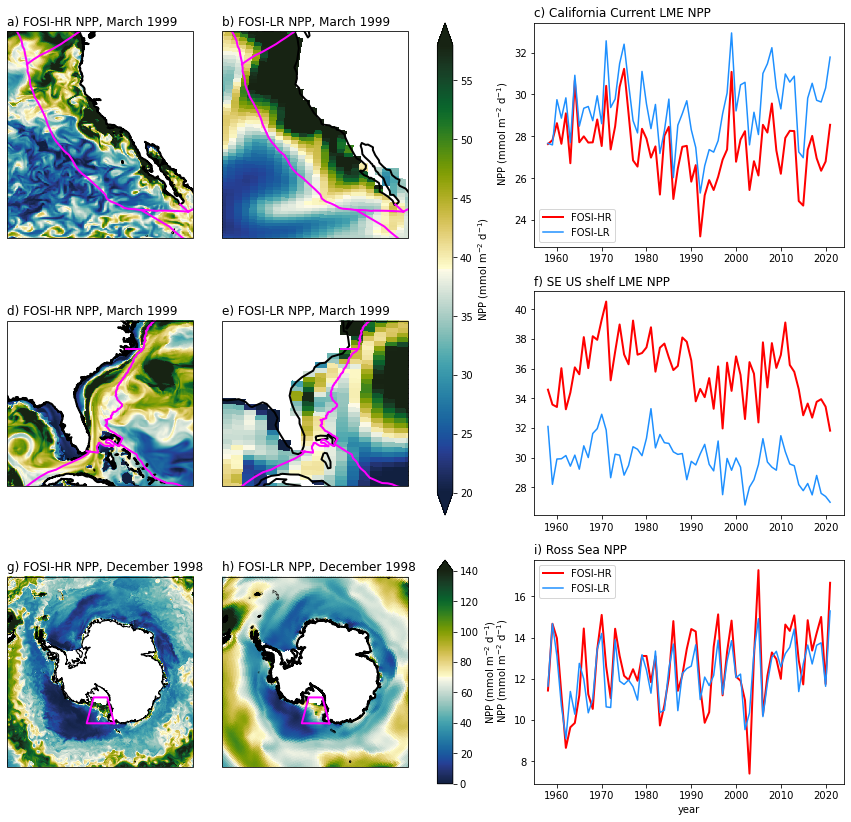

In [48]:
fig = plt.figure(figsize=(15, 14))

gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1.2, 1.2, 0.1, 0.15, 2))

prj = ccrs.PlateCarree()

ax_ca_curr01 = plt.subplot(gs[0, 0], projection=prj)
ax_ca_curr1 = plt.subplot(gs[0, 1], projection=prj)
ax_ca_curr_ts = plt.subplot(gs[0, 4])

ax_se_us01 = plt.subplot(gs[1, 0], projection=prj)
ax_se_us1 = plt.subplot(gs[1, 1], projection=prj)
ax_se_us_ts = plt.subplot(gs[1, 4])

cax_npp = plt.subplot(gs[0:2, 2])

prj = ccrs.SouthPolarStereo()
ax_antarc01 = plt.subplot(gs[2, 0], projection=prj)
ax_antarc1 = plt.subplot(gs[2, 1], projection=prj)
ax_antarc_ts = plt.subplot(gs[2, 4])

cax_npp2 = plt.subplot(gs[2, 2])

### CA current####################################################
ax_ca_curr01.set_title('a) FOSI-HR NPP, March 1999', loc='left')
ax_ca_curr01.set_extent([-135, -108, 18, 48], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_ca_curr01.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_ca_curr01.coastlines('10m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_ca_curr01.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    
    
ax_ca_curr1.set_title('b) FOSI-LR NPP, March 1999', loc='left')
ax_ca_curr1.set_extent([-135, -108, 18, 48], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_ca_curr1.pcolormesh(lon,lat,field, transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_ca_curr1.coastlines('110m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_ca_curr1.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    

####### CA curr timeseries

ax_ca_curr_ts.set_title('c) California Current LME NPP',loc='left')
v='photoC_TOT_zint'
ax_ca_curr_ts.plot(years, ts_by_lme_dict_x01[3][v]* convert, color='red', linewidth=2, label='FOSI-HR')
ax_ca_curr_ts.plot(years, ts_by_lme_dict_x1[3][v]* convert, color='dodgerblue', linewidth=1.5, label='FOSI-LR')
ax_ca_curr_ts.set(ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
ax_ca_curr_ts.legend()

###### NPP colorbar################################################################
cb_npp = plt.colorbar(pc, cax=cax_npp,extend='both', label='NPP (mmol m$^{-2}$ d$^{-1}$)')


################## SE US shelf###########################################

ax_se_us01.set_title('d) FOSI-HR NPP, March 1999', loc='left')
ax_se_us01.set_extent([-88, -70, 22, 38], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_se_us01.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_se_us01.coastlines('10m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_se_us01.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    
    
ax_se_us1.set_title('e) FOSI-LR NPP, March 1999', loc='left')
ax_se_us1.set_extent([-88, -70, 22, 38], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_se_us1.pcolormesh(lon,lat,field, transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_se_us1.coastlines('110m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_se_us1.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    
####### SE US timeseries

ax_se_us_ts.set_title('f) SE US shelf LME NPP',loc='left')
v='photoC_TOT_zint'
ax_se_us_ts.plot(years, ts_by_lme_dict_x01[6][v]* convert, color='red', linewidth=2, label='FOSI-HR')
ax_se_us_ts.plot(years, ts_by_lme_dict_x1[6][v]* convert, color='dodgerblue', linewidth=1.5, label='FOSI-LR')
#ax_se_us_ts.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
#ax.legend()


########################### Antarctic / Ross Sea###########################

ax_antarc01.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

ax_antarc01.set_title('g) FOSI-HR NPP, December 1998', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=491)*0.01*86400.)

pc = ax_antarc01.pcolormesh(lon,lat,field,
                   transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=0,vmax=140)
                  #vmin=0,vmax=150)


ax_antarc01.coastlines('10m',linewidth=1)

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_antarc01.plot(lon_pts, lat_pts, color="magenta", linewidth=2,transform=ccrs.PlateCarree())

    
############### 

ax_antarc1.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

ax_antarc1.set_title('h) FOSI-LR NPP, December 1998', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=491)*0.01*86400.)

pc2 = ax_antarc1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=0,vmax=140)
                    #vmin=0,vmax=150)

ax_antarc1.coastlines('10m',linewidth=2)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_antarc1.plot(lon_pts, lat_pts, color="magenta", linewidth=2,transform=ccrs.PlateCarree())

########### timeseries
ax_antarc_ts.set_title('i) Ross Sea NPP',loc='left')
v='photoC_TOT_zint'
ax_antarc_ts.plot(years, ts_Ross_x01[v]* convert, color='red', linewidth=2, label='FOSI-HR')
ax_antarc_ts.plot(years, ts_Ross_x1[v]* convert, color='dodgerblue', linewidth=1.5, label='FOSI-LR')
ax_antarc_ts.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
#ax.legend()
ax_antarc_ts.legend()

###### NPP colorbar
cb_npp2 = plt.colorbar(pc2, cax=cax_npp2,extend='max', label='NPP (mmol m$^{-2}$ d$^{-1}$)')




fig.savefig('/glade/work/kristenk/figs/Fig_US_LME_res_compare.png', bbox_inches='tight', dpi=300, format='png');

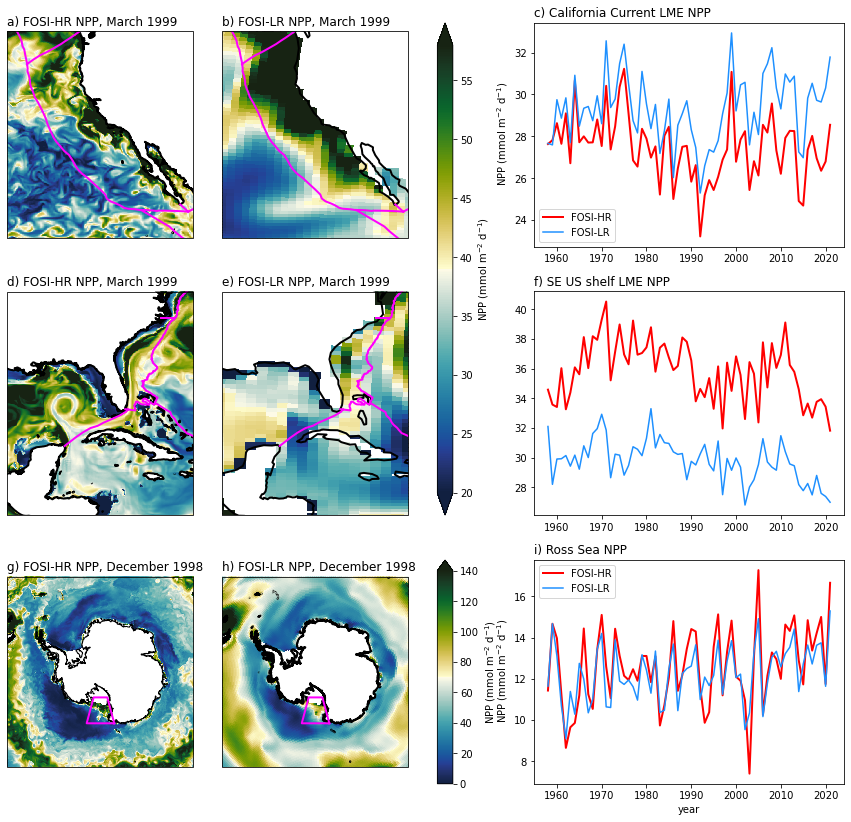

In [52]:
fig = plt.figure(figsize=(15, 14))

gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1.2, 1.2, 0.1, 0.15, 2))

prj = ccrs.PlateCarree()

ax_ca_curr01 = plt.subplot(gs[0, 0], projection=prj)
ax_ca_curr1 = plt.subplot(gs[0, 1], projection=prj)
ax_ca_curr_ts = plt.subplot(gs[0, 4])

ax_se_us01 = plt.subplot(gs[1, 0], projection=prj)
ax_se_us1 = plt.subplot(gs[1, 1], projection=prj)
ax_se_us_ts = plt.subplot(gs[1, 4])

cax_npp = plt.subplot(gs[0:2, 2])

prj = ccrs.SouthPolarStereo()
ax_antarc01 = plt.subplot(gs[2, 0], projection=prj)
ax_antarc1 = plt.subplot(gs[2, 1], projection=prj)
ax_antarc_ts = plt.subplot(gs[2, 4])

cax_npp2 = plt.subplot(gs[2, 2])

### CA current####################################################
ax_ca_curr01.set_title('a) FOSI-HR NPP, March 1999', loc='left')
ax_ca_curr01.set_extent([-135, -108, 18, 48], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_ca_curr01.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_ca_curr01.coastlines('10m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_ca_curr01.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    
    
ax_ca_curr1.set_title('b) FOSI-LR NPP, March 1999', loc='left')
ax_ca_curr1.set_extent([-135, -108, 18, 48], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_ca_curr1.pcolormesh(lon,lat,field, transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_ca_curr1.coastlines('110m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_ca_curr1.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    

####### CA curr timeseries

ax_ca_curr_ts.set_title('c) California Current LME NPP',loc='left')
v='photoC_TOT_zint'
ax_ca_curr_ts.plot(years, ts_by_lme_dict_x01[3][v]* convert, color='red', linewidth=2, label='FOSI-HR')
ax_ca_curr_ts.plot(years, ts_by_lme_dict_x1[3][v]* convert, color='dodgerblue', linewidth=1.5, label='FOSI-LR')
ax_ca_curr_ts.set(ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
ax_ca_curr_ts.legend()

###### NPP colorbar################################################################
cb_npp = plt.colorbar(pc, cax=cax_npp,extend='both', label='NPP (mmol m$^{-2}$ d$^{-1}$)')


################## SE US shelf###########################################

ax_se_us01.set_title('d) FOSI-HR NPP, March 1999', loc='left')
ax_se_us01.set_extent([-93, -73, 14, 38], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_se_us01.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_se_us01.coastlines('10m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_se_us01.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    
    
ax_se_us1.set_title('e) FOSI-LR NPP, March 1999', loc='left')
ax_se_us1.set_extent([-93, -73, 14, 38], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=ts)*0.01*86400.)
pc = ax_se_us1.pcolormesh(lon,lat,field, transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=20,vmax=58)
ax_se_us1.coastlines('110m',linewidth=2)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax_se_us1.plot(x,y,transform=ccrs.PlateCarree(),color='magenta',linewidth=2)
    
####### SE US timeseries

ax_se_us_ts.set_title('f) SE US shelf LME NPP',loc='left')
v='photoC_TOT_zint'
ax_se_us_ts.plot(years, ts_by_lme_dict_x01[6][v]* convert, color='red', linewidth=2, label='FOSI-HR')
ax_se_us_ts.plot(years, ts_by_lme_dict_x1[6][v]* convert, color='dodgerblue', linewidth=1.5, label='FOSI-LR')
#ax_se_us_ts.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
#ax.legend()


########################### Antarctic / Ross Sea###########################

ax_antarc01.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

ax_antarc01.set_title('g) FOSI-HR NPP, December 1998', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=491)*0.01*86400.)

pc = ax_antarc01.pcolormesh(lon,lat,field,
                   transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=0,vmax=140)
                  #vmin=0,vmax=150)


ax_antarc01.coastlines('10m',linewidth=1)

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_antarc01.plot(lon_pts, lat_pts, color="magenta", linewidth=2,transform=ccrs.PlateCarree())

    
############### 

ax_antarc1.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

ax_antarc1.set_title('h) FOSI-LR NPP, December 1998', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=491)*0.01*86400.)

pc2 = ax_antarc1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=0,vmax=140)
                    #vmin=0,vmax=150)

ax_antarc1.coastlines('10m',linewidth=2)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_antarc1.plot(lon_pts, lat_pts, color="magenta", linewidth=2,transform=ccrs.PlateCarree())

########### timeseries
ax_antarc_ts.set_title('i) Ross Sea NPP',loc='left')
v='photoC_TOT_zint'
ax_antarc_ts.plot(years, ts_Ross_x01[v]* convert, color='red', linewidth=2, label='FOSI-HR')
ax_antarc_ts.plot(years, ts_Ross_x1[v]* convert, color='dodgerblue', linewidth=1.5, label='FOSI-LR')
ax_antarc_ts.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
#ax.legend()
ax_antarc_ts.legend()

###### NPP colorbar
cb_npp2 = plt.colorbar(pc2, cax=cax_npp2,extend='max', label='NPP (mmol m$^{-2}$ d$^{-1}$)')




fig.savefig('/glade/work/kristenk/figs/Fig_US_LME_res_compare.png', bbox_inches='tight', dpi=300, format='png');

In [55]:
(ts_Ross_x01[v]* convert).std(dim='time')

<xarray.DataArray 'photoC_TOT_zint' ()>
array(1.87978824)

In [57]:
(ts_Ross_x1[v]* convert).std(dim='time')

<xarray.DataArray 'photoC_TOT_zint' ()>
array(1.37383625)

In [58]:
cluster.close()